# MC-PCA on non-detrended speleothem data

This Jupyter Notebook provides an analysis of speleothem oxygen isotope data using the Monte Carlo Principal Component Analysis (MC-PCA) method. Speleothems are cave formations that contain valuable climate information, and the oxygen isotope composition of speleothems can provide insights into past climate conditions.

The notebook utilizes various Python libraries such as pandas, numpy, matplotlib, seaborn, and pyleoclim to import, process, and analyze the speleothem data. The MC-PCA method is implemented using custom classes, including MultipleEnsembleGeoSeries and MultipleMultivarDecomp, which facilitate the analysis of multiple speleothem records simultaneously. These classes will be incorporated into [Pyleoclim](https://pyleoclim-util.readthedocs.io/).

The notebook includes cells that import necessary modules, load the speleothem data from a pickle file, define variables, and perform data visualization and analysis. The data is organized into different sets, such as EA_set and IB_set, representing speleothems from different regions. The MC-PCA method allows for the decomposition of the data into principal components, which can reveal underlying patterns and trends in the oxygen isotope data.

In [1]:
import pickle

from tqdm import tqdm

import pyleoclim as pyleo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

from matplotlib import cm
from matplotlib.gridspec import GridSpec

In [2]:
with open('../data/ens_dict.pkl','rb') as handle: #Using un preprocessed data
    ens_dict = pickle.load(handle)

#Separating spels into two sets. Exclude Mawmluh for PCA
EA_set = [
    'Jiuxian',
    'Xianglong',
    'Heshang',
    'Lianhua',
    'Dongge',
#    'Guizhouxinv', this gets excluded due to its short length
    'Jiulong',
    'Liuli',
]

IB_set = [
    'Sahiya',
    'Hoq',
    'Tangga',
    'Oman',
    'LaVierge'
]

all_set = EA_set + IB_set

First we'll analyze all of the speleothems together:

In [3]:
# Create multipleensemblegeoseries object, slicing off each timeseries at 3000 and 5000 years bp
megs = pyleo.MulEnsGeoSeries(list(ens_dict[label].interp().slice((3000,5000)) for label in all_set),label="All Speleothems")

In [4]:
#Applying mcpca to the multipleensemblegeoseries object
megs_pca = megs.mcpca(seed=42)

Iterating over simulations:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating over simulations: 100%|██████████| 1000/1000 [00:05<00:00, 180.59it/s]


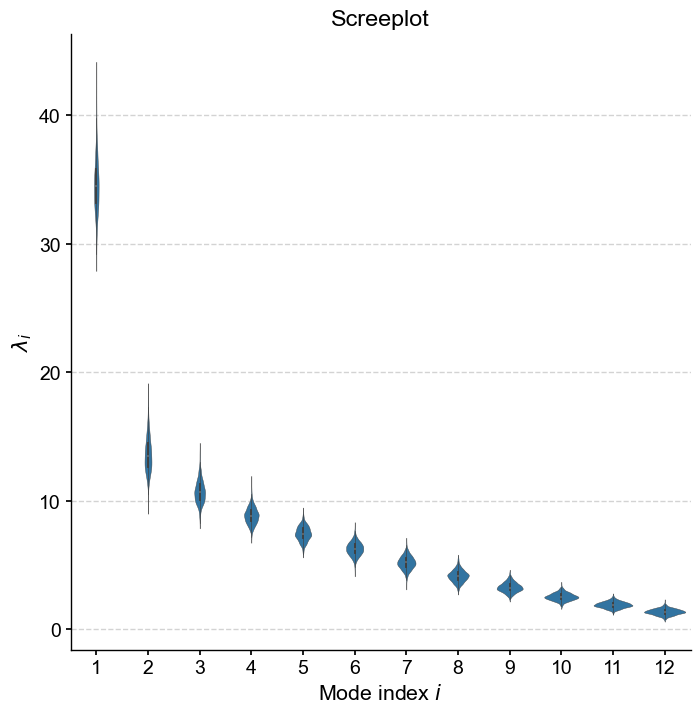

In [5]:
#plotting
fig,ax = megs_pca.screeplot(figsize=(8,8))

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 859.78it/s]


(5000.0, 3000.0)

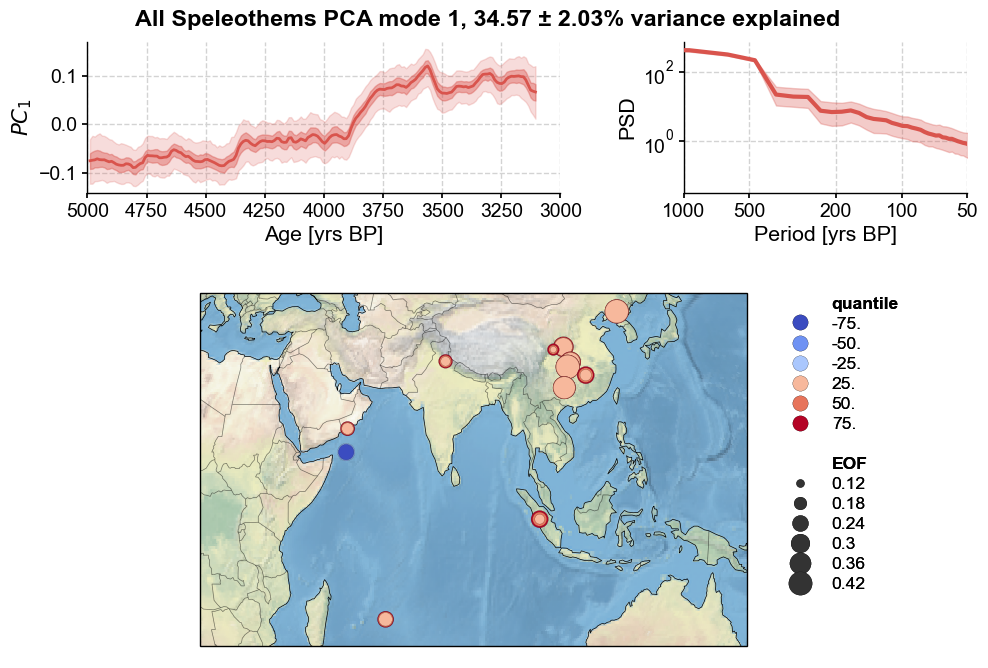

In [6]:
fig,ax = megs_pca.modeplot(index=0,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[20,150,-25,45]})
ax['pc'].set_xlim([5000,3000])

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 883.09it/s]


(5000.0, 3000.0)

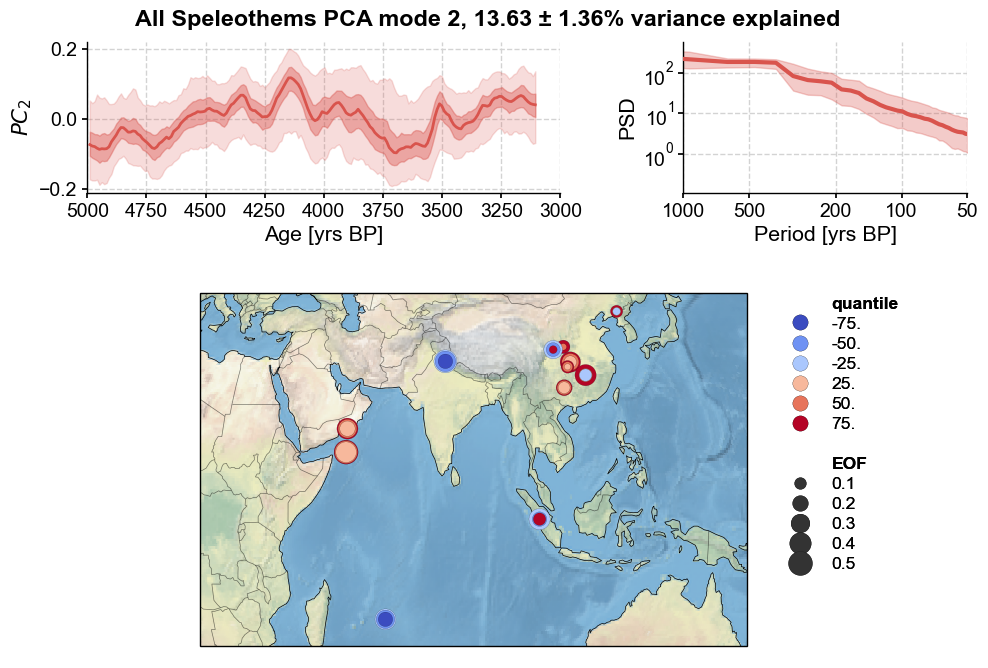

In [7]:
fig,ax = megs_pca.modeplot(index=1,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[20,150,-25,45]})
ax['pc'].set_xlim([5000,3000])

Now just the East Asian speleothems:

In [8]:
megs_ea = pyleo.MulEnsGeoSeries(list(ens_dict[label].interp().slice((3000,5000)) for label in EA_set),label='East Asian Speleothems')

In [9]:
megs_ea_pca = megs_ea.mcpca(seed=42)

Iterating over simulations: 100%|██████████| 1000/1000 [00:03<00:00, 257.67it/s]


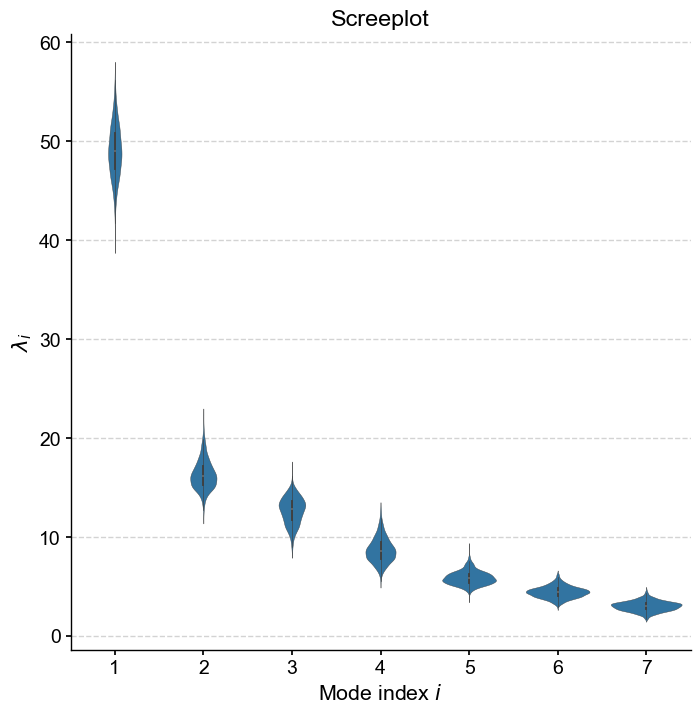

In [10]:
fig,ax = megs_ea_pca.screeplot()

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 848.47it/s]


(5000.0, 3000.0)

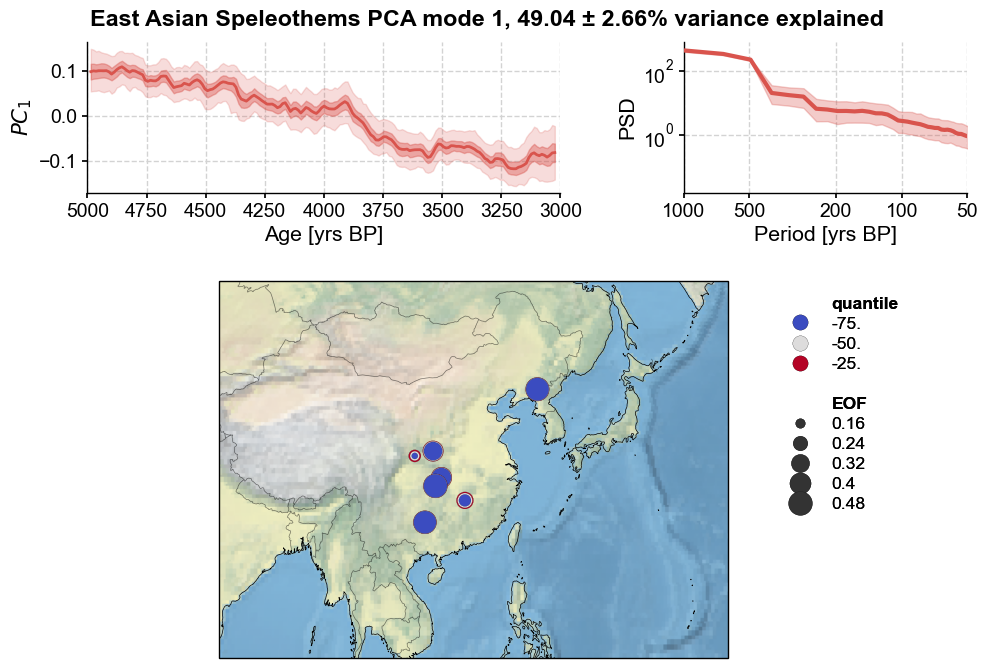

In [11]:
fig,ax = megs_ea_pca.modeplot(index=0,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[80,150,10,55]})
ax['pc'].set_xlim([5000,3000])

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 878.12it/s]


(5000.0, 3000.0)

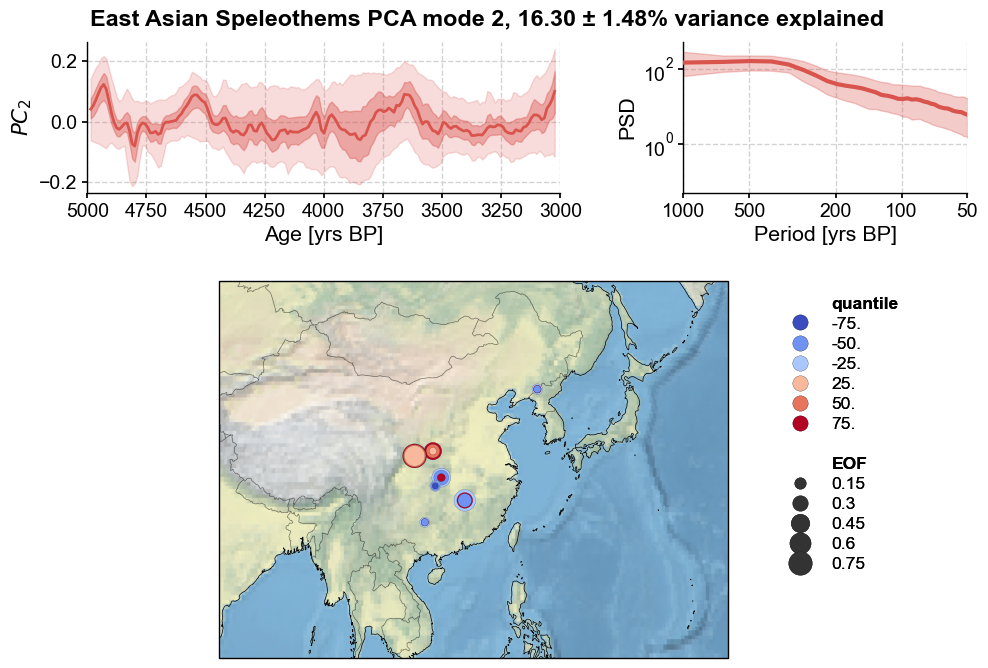

In [12]:
fig,ax = megs_ea_pca.modeplot(index=1,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[80,150,10,55]})
ax['pc'].set_xlim([5000,3000])

Now just the speleothems from around the Indian Ocean Basin:

In [13]:
megs_ib = pyleo.MulEnsGeoSeries(list(ens_dict[label].interp().slice((3000,5000)) for label in IB_set),label='Indian Ocean Basin Speleothems')

In [14]:
megs_ib_pca = megs_ib.mcpca(seed=42)

Iterating over simulations: 100%|██████████| 1000/1000 [00:03<00:00, 252.39it/s]


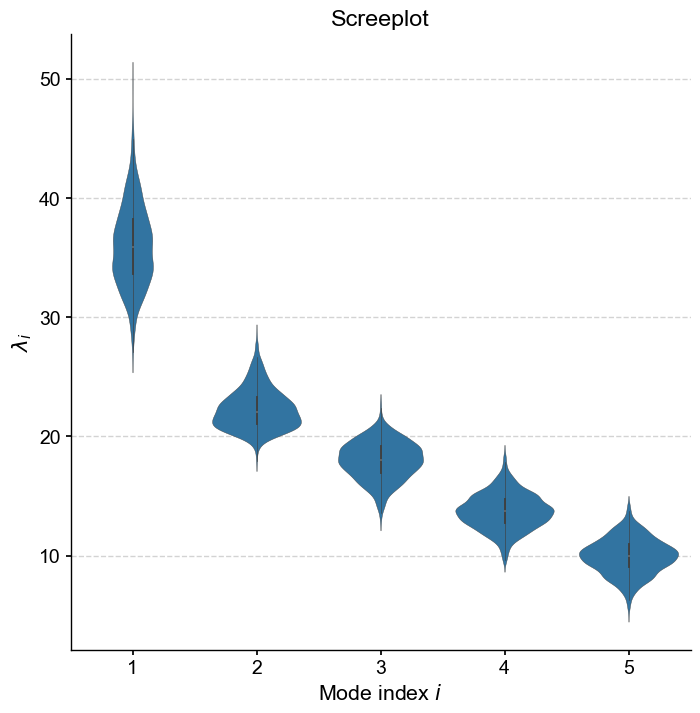

In [15]:
fig,ax = megs_ib_pca.screeplot()

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 787.05it/s]


(5000.0, 3000.0)

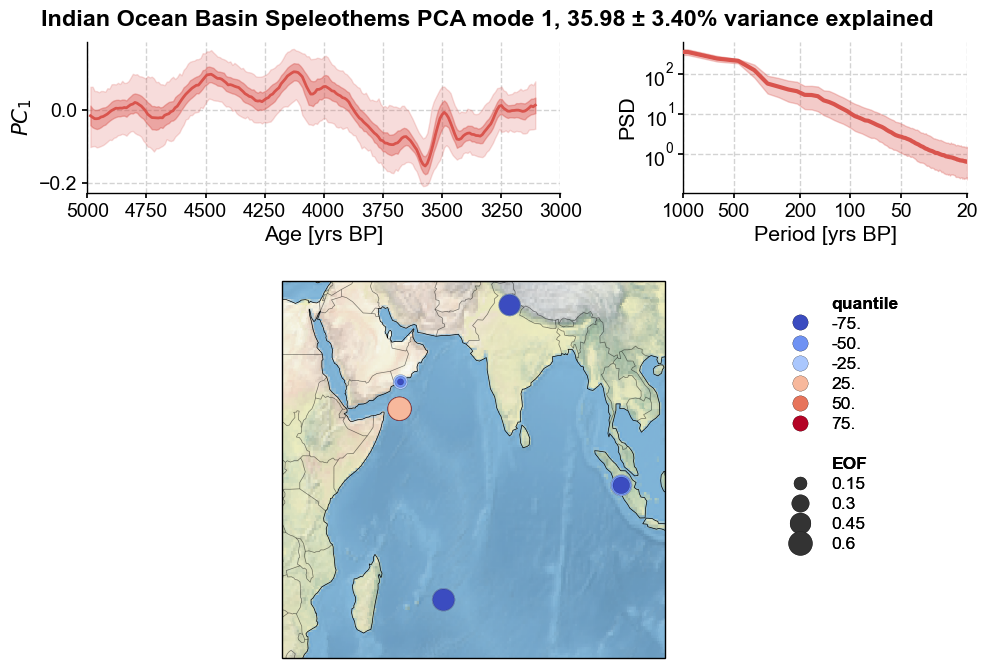

In [16]:
fig,ax = megs_ib_pca.modeplot(index=0,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[30,110,-30,35]})
ax['pc'].set_xlim([5000,3000])

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 783.87it/s]


(5000.0, 3000.0)

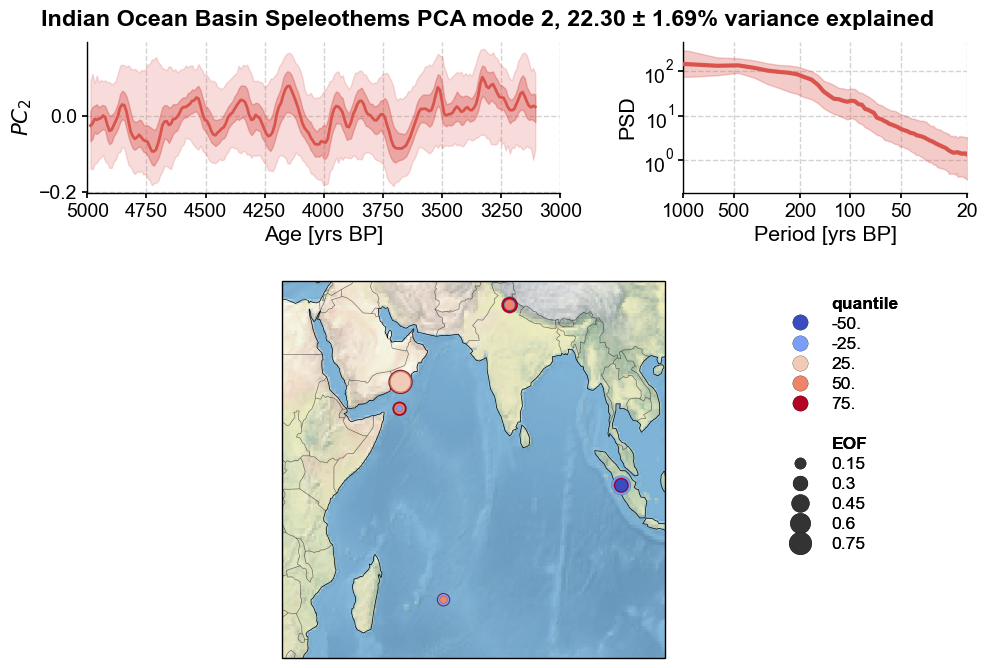

In [17]:
fig,ax = megs_ib_pca.modeplot(index=1,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[30,110,-30,35]})
ax['pc'].set_xlim([5000,3000])